✅ Using NumPy with CPU.
Loading matrices from matrices_nfftlog128_Afull-False_use_TNS-False.npy
[FOLPS] Model Pk: EFT, damping: None (WARNING: EFT does not use damping, ignoring damping)


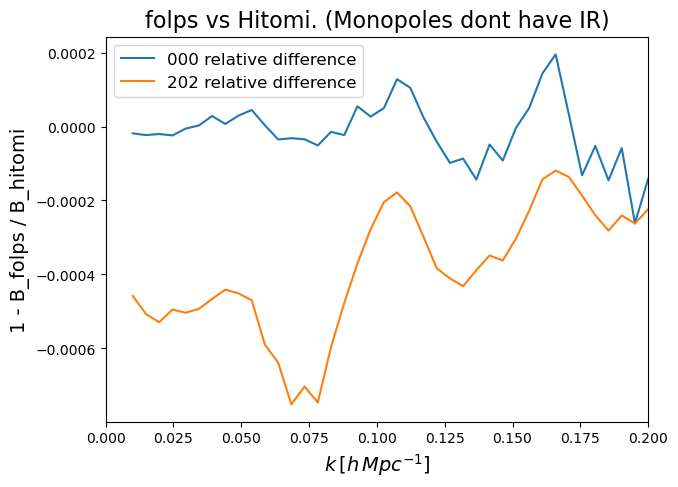

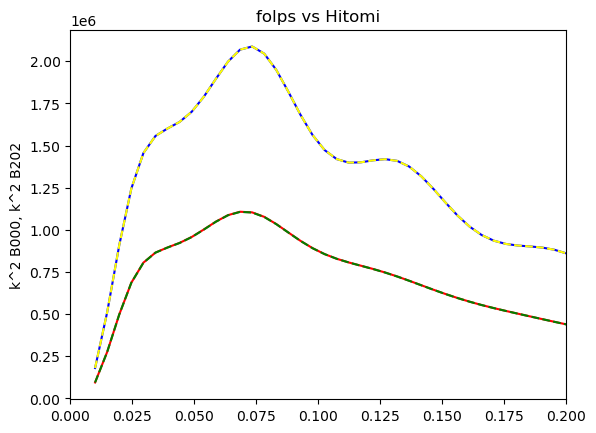

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import folps as FOLPS

## Compare with Carol/Hitomi data

precision=[62,62,62]
#precision=[18,62,62]

qpar,qperp=1,1

k_evb = np.linspace(0.01,0.2, num = 40) 
k_ev_bk=np.vstack([k_evb,k_evb]).T   # List of pairs of k. (B=B(k1,k2))


#omega_i = Omega_i h² 
omega_b = 0.0224;        #baryons
omega_cdm = 0.12;       #CDM
omega_ncdm = 0.000;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.0;                 #evaluation redshift
# if z_pk < 0.0000000000001:
#     qpar,qperp = 1,1

Omega_m = (omega_cdm+omega_b+omega_ncdm)/h**2
fnu = omega_ncdm/(omega_cdm+omega_b+omega_ncdm)
# CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]  //Deprecated. Now folps uses kwargs

kwargs = {'z': z_pk,
          'h': h,
          'Omega_m': Omega_m,
          # 'f0': np.float64(0.6880638641959066),  #if not provided, the code computes it
          'fnu': fnu,
         }

f0=FOLPS.f0_function(z_pk,Omega_m)    
    
# CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


inputpkT = np.loadtxt('H_pk_linear.txt', unpack = True)

#bias parameters
b1, b2, bs2,b3nl = 1,0,0,0;                 

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]


matrix = FOLPS.MatrixCalculator(A_full=False) 
mmatrices = matrix.get_mmatrices()

k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 30) # array of k_ev in [h/Mpc]

nonlinear = FOLPS.NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,kernels='fk',**kwargs)
table, table_nonwiggles = nonlinear.calculate_loop_table(k=inputpkT[0], pklin=inputpkT[1],cosmo=None, **kwargs)
multipoles = FOLPS.RSDMultipolesPowerSpectrumCalculator() 
pkl0, pkl2, pkl4  = multipoles.get_rsd_pkell(kobs=k_ev, qpar=qpar, qper=qperp, pars=NuisanParams,
                                       table=table, table_now=table_nonwiggles,
                                       bias_scheme='folps', damping='lor'
                                       )
kh=k_ev


# matrices = FOLPS.Matrices()
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 30) # array of k_ev in [h/Mpc]
k_ev = k_evb

Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1=0
c2=0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
bisp_cosmo_params = [z_pk,(omega_cdm+omega_b+omega_ncdm)/h**2,h]

## compute quadrupole withouth IR
k_pkl_pklnw=np.array([table[0], table[1], table[1]])
qpar,qperp=1,1

bispectrum = FOLPS.BispectrumCalculator()
Bk = bispectrum.Sugiyama_Bl1l2L(
        k_ev_bk,
        f0,
        bisp_nuis_params,
        qpar=qpar,
        qper=qperp,
        k_pkl_pklnw=k_pkl_pklnw,
        precision=precision,
        renormalize=True,
        damping=None,
        interpolation_method='cubic'
    )


B000, B110, B220, B202, B022_borrar, B112 = Bk


loaded_data = np.loadtxt('H_Carol_monopole.txt')
k_ev_C = loaded_data[:, 0]
B000_C = loaded_data[:, 1]


## compute quadrupole with IR
precision=[62,62,62]
k_pkl_pklnw=np.array([table[0], table[1], table_nonwiggles[1]])


Bk_2 = bispectrum.Sugiyama_Bl1l2L(
        k_ev_bk,
        f0,
        bisp_nuis_params,
        qpar=qpar,
        qper=qperp,
        k_pkl_pklnw=k_pkl_pklnw,
        precision=precision,
        renormalize=True,
        damping=None,
        interpolation_method='cubic'
    )

B000_borrar, B110, B220, B202, B022, B112 = Bk_2


B202_C_old = np.loadtxt('H_bk202_hit.txt')
B202_k_old = np.loadtxt('H_k_new.txt')

B202_C = FOLPS.interpolation_l(k_ev, B202_k_old, B202_C_old)


fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'1 - B_folps / B_hitomi', fontsize =  14)

axs.plot(k_ev, -(B000/B000_C - 1), label=r'000 relative difference')
axs.plot(k_ev, -(B202/B202_C - 1), label=r'202 relative difference')
axs.legend(fontsize=12, loc='best')
axs.set_title('folps vs Hitomi. (Monopoles dont have IR)', fontsize=16, pad=7)

axs.set_xlim([0, 0.2])
plt.show()


plt.plot(k_ev,k_ev*k_ev*B000,ls='-',color='blue')
plt.plot(k_ev,k_ev*k_ev*B202,ls='-',color='red')
plt.plot(k_ev,k_ev*k_ev*B000_C,ls='--',color='yellow')
plt.plot(k_ev,k_ev*k_ev*B202_C,ls='--',color='green')

plt.title(r'folps vs Hitomi')
plt.ylabel('k^2 B000, k^2 B202')
plt.xlim(0,0.20)
plt.show()